Reading and augmetung DICOM image files during training is expensive. We generate an HDF5 file that contains all the images and labels which is much more performant during training time.  

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import pydicom
import h5py

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from matplotlib.pyplot import imread
import glob
import os
import random
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

In [3]:
# convert pathology values to 0,1, or 2
label_encoder = LabelEncoder()

# Get labels from images
def get_label_dict(df_info, path_column, test=False):
    # Just want the 1st part from the image path
    df_info['image_path_base_dir'] = df_info[path_column].apply(lambda x: x[:x.find('/')])
    bc_callback_indices = df_info[df_info['pathology'] == 'BENIGN_WITHOUT_CALLBACK'].index
    df_info.loc[list(bc_callback_indices), 'pathology'] = 'BENIGN'

    if test:
        df_info['pathlogy_label'] = label_encoder.transform(df_info['pathology'])
    else:
        df_info['pathlogy_label'] = label_encoder.fit_transform(df_info['pathology'])
    # key-value => image_path: pathology_value (eg malignant or benign)
    label_dict = pd.Series(df_info['pathlogy_label'].values,index=df_info['image_path_base_dir']).to_dict()
    return label_dict
    
df_train_info = pd.read_csv('Mass-Full-Images_CBIS-DDSM/mass_case_description_train_set.csv')
df_test_info = pd.read_csv('Mass-Full-Images_CBIS-DDSM/mass_case_description_test_set.csv')

train_label_dict = get_label_dict(df_train_info, 'image file path')
test_label_dict = get_label_dict(df_test_info, 'image file path', test=True)

train_cropped_label_dict = get_label_dict(df_train_info, 'cropped image file path')
test_cropped_label_dict = get_label_dict(df_test_info, 'cropped image file path', test=True)

In [5]:
print(test_cropped_label_dict)

{'Mass-Test_P_00016_LEFT_CC_1': 1, 'Mass-Test_P_00016_LEFT_MLO_1': 1, 'Mass-Test_P_00017_LEFT_CC_1': 1, 'Mass-Test_P_00017_LEFT_MLO_1': 1, 'Mass-Test_P_00032_RIGHT_CC_1': 0, 'Mass-Test_P_00032_RIGHT_MLO_1': 0, 'Mass-Test_P_00037_RIGHT_CC_1': 1, 'Mass-Test_P_00037_RIGHT_MLO_1': 1, 'Mass-Test_P_00056_LEFT_MLO_1': 0, 'Mass-Test_P_00066_LEFT_CC_1': 1, 'Mass-Test_P_00066_LEFT_MLO_1': 1, 'Mass-Test_P_00099_LEFT_MLO_1': 0, 'Mass-Test_P_00114_LEFT_MLO_1': 0, 'Mass-Test_P_00116_RIGHT_CC_1': 1, 'Mass-Test_P_00116_RIGHT_CC_2': 1, 'Mass-Test_P_00116_RIGHT_MLO_1': 1, 'Mass-Test_P_00116_RIGHT_MLO_2': 1, 'Mass-Test_P_00118_RIGHT_CC_1': 1, 'Mass-Test_P_00118_RIGHT_MLO_1': 1, 'Mass-Test_P_00124_RIGHT_CC_1': 0, 'Mass-Test_P_00126_RIGHT_CC_1': 0, 'Mass-Test_P_00126_RIGHT_MLO_1': 0, 'Mass-Test_P_00131_LEFT_CC_1': 0, 'Mass-Test_P_00131_LEFT_MLO_1': 0, 'Mass-Test_P_00145_LEFT_CC_1': 0, 'Mass-Test_P_00145_LEFT_MLO_1': 0, 'Mass-Test_P_00147_RIGHT_CC_1': 1, 'Mass-Test_P_00147_RIGHT_MLO_1': 1, 'Mass-Test_P_0015

Generate the HDF5 file with actual image and label data using the two dictionaries created above.

In [4]:
train_cropped_root_path = 'Mass-Full-Images_CBIS-DDSM/Training-cropped'
test_cropped_root_path = 'Mass-Full-Images_CBIS-DDSM/Test-cropped'

# Get list of all files with .dcm extension for train and test images
train_cropped_filenames = glob.glob(os.path.join('Mass-Full-Images_CBIS-DDSM/Training-cropped', '**', '*.dcm'), recursive=True)
test_cropped_filenames = glob.glob(os.path.join('Mass-Full-Images_CBIS-DDSM/Test-cropped', '**', '*.dcm'), recursive=True)


with h5py.File('ddsm_cropped_all.hdf5', mode='w') as hdf5_file:
    # create placeholders for image data and labels in the hdf5 file
    hdf5_file.create_dataset("data", (1696, 224, 224), np.float32)
    hdf5_file.create_dataset("labels", (1696,), np.int32)

    transform = transforms.Compose([transforms.Resize((224, 224))])

    i = 0
    for fn in train_cropped_filenames:
        # read in the DICOM file data (including metadata)
        path_excluding_root_path = fn[len(train_cropped_root_path) + 1:]
        image_path_base_dir = path_excluding_root_path[:path_excluding_root_path.find('\\')]
        ds = pydicom.read_file(fn)
        # Only consider the file if it is marked as "cropped images"
        if ds.SeriesDescription == 'cropped images':
            # read in the actual pixel array from the DICOM file data
            image = Image.fromarray(ds.pixel_array.astype(float))
            # apply the transform and convert to numpy array
            t = np.array(transform(image))
            # read corresponding label from the dictionary created earlier
            label = train_cropped_label_dict[image_path_base_dir]
            # append the image and label data to the corresponding index of the HDF5 file
            hdf5_file["data"][i, ...] = t
            hdf5_file["labels"][i] = label
            i += 1
    
    for fn in test_cropped_filenames:
        path_excluding_root_path = fn[len(test_cropped_root_path) + 1:]
        image_path_base_dir = path_excluding_root_path[:path_excluding_root_path.find('\\')]
        ds = pydicom.read_file(fn)
        if ds.SeriesDescription == 'cropped images':
            image = Image.fromarray(ds.pixel_array.astype(float))
            t = np.array(transform(image))
            label = test_cropped_label_dict[image_path_base_dir]
            hdf5_file["data"][i, ...] = t
            hdf5_file["labels"][i] = label
            i += 1

In [6]:
with h5py.File('ddsm_cropped_all.hdf5', mode='r') as hdf5_file:
    labels = np.array(hdf5_file['labels'])
    print(labels)

[1 1 0 ... 1 1 1]


In [10]:
df = pd.DataFrame({'label': labels})
df['number'] = df.index

x = df['number'].values
y = df['label'].values

# apply 5-fold stratified split on the indices (in the number column of the dataframe)
skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(x, y)

cv_indices = []
# in this loop, train_index is the list of indices of the benign images, 
# test_index is the list of indices of the malignant images
for train_index, test_index in skf.split(x, y):
    cv_indices.append([np.array(train_index), np.array(test_index)])

print(cv_indices[0])

[array([   0,    1,    2, ..., 1692, 1693, 1694]), array([   8,   10,   14,   18,   20,   23,   26,   32,   34,   35,   41,
         46,   48,   50,   53,   62,   70,   72,   73,   81,   83,   90,
         92,   98,   99,  100,  111,  116,  120,  124,  126,  128,  129,
        135,  137,  140,  141,  144,  149,  152,  153,  155,  165,  167,
        169,  170,  171,  172,  173,  175,  177,  183,  189,  193,  199,
        214,  216,  218,  229,  242,  246,  247,  251,  257,  263,  264,
        272,  274,  275,  295,  299,  301,  308,  309,  311,  313,  315,
        316,  320,  321,  325,  328,  333,  336,  338,  340,  344,  350,
        355,  356,  359,  364,  367,  372,  380,  397,  402,  404,  415,
        423,  424,  426,  432,  452,  455,  460,  470,  476,  484,  485,
        490,  493,  499,  504,  508,  514,  522,  528,  533,  545,  551,
        554,  555,  558,  560,  564,  567,  568,  573,  581,  584,  586,
        587,  600,  604,  612,  616,  618,  624,  626,  633,  638,  658,


In [7]:
# add the indices for the 5 splits to the HDF5 file as well
with h5py.File('ddsm_cropped_all.hdf5', mode='a') as hdf5_file:
    hdf5_file.create_dataset("cv_indices_train_0", data=cv_indices[0][0])
    hdf5_file.create_dataset("cv_indices_train_1", data=cv_indices[1][0])
    hdf5_file.create_dataset("cv_indices_train_2", data=cv_indices[2][0])
    hdf5_file.create_dataset("cv_indices_train_3", data=cv_indices[3][0])
    hdf5_file.create_dataset("cv_indices_train_4", data=cv_indices[4][0])
    hdf5_file.create_dataset("cv_indices_test_0", data=cv_indices[0][1])
    hdf5_file.create_dataset("cv_indices_test_1", data=cv_indices[1][1])
    hdf5_file.create_dataset("cv_indices_test_2", data=cv_indices[2][1])
    hdf5_file.create_dataset("cv_indices_test_3", data=cv_indices[3][1])
    hdf5_file.create_dataset("cv_indices_test_4", data=cv_indices[4][1])

## Exploratory Analysis - Visualize Class Distribution

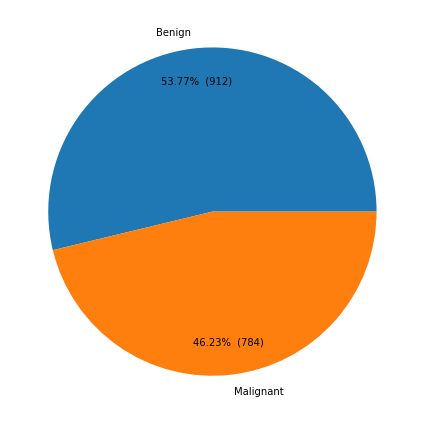

In [24]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

classes = ['Benign', 'Malignant']
fig = plt.figure(figsize=(6,6))

labels_all = np.array(list(train_label_dict.values()) + list(test_label_dict.values()))

malignant_count = labels.sum()
benign_count = len(labels) - malignant_count
counts = [benign_count, malignant_count]

ax = plt.pie(counts, labels=classes, autopct=make_autopct(counts), pctdistance=0.8, labeldistance=1.1)
# plt.title('Class Distribution',  y=-0.1)
plt.tight_layout()
plt.savefig('dist.png')
plt.show()